In [1]:
using Lattices
using LinearAlgebra
using Combinatorics
using SparseArrays
using Plots
import Graphs
using LaTeXStrings
using Statistics
using Random
using Zygote
using Optimization, OptimizationOptimisers
using JSON

include("ed_objects.jl")
include("ed_functions.jl")
include("ed_optimization.jl")
include("utility_Functions.jl")

append_to_json_files (generic function with 1 method)

In [ ]:
using JLD2

jldsave(raw"D:\datasets\dqmc_hubbard\ED.jld2"; E=E, V=U,t=1, U=8,mu=2, half_filling=true, N_up=4, N_down=4, lattice=lattice)

In [4]:
using JLD2

d = load(raw"D:\datasets\dqmc_hubbard\ED.jld2")
V = d["V"]
lattice = d["lattice"]
t = d["t"]
E = d["E"]
μ = d["mu"]
N_up = d["N_up"]
N_down = d["N_down"]

4

# eigenstate comparison

In [2]:
# using KrylovKit

t = 1.0
U = 6
μ = 0  # positive incentivises fewer particles (one electron costs this much energy)
# N_up = 2
# N_down = 2
N = 5
half_filling = false
# lattice = Chain(6, Periodic())
lattice = Square((2,3), Periodic())
# lattice = Graphs.cycle_graph(3)

models = []

reference_index = 2
t_values = []# Float64[1,1], Float64[1,0.1], 1.0]
# for _t in t_values
#     # println(_t)
#     push!(models,HubbardModel(_t,0.0001,μ,half_filling))
# end
U_values = [0,0.01,0.2, 1,1.001,3,4,5,7,10, 100]
for U in U_values
    # println(t)
    push!(models,HubbardModel(t,U,μ,half_filling))
end

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)

ops = []
push!(ops,Matrix(create_operator(subspace,:Sx)))
push!(ops, Matrix(create_operator(subspace,:S2)))
# op3 = Matrix(create_operator(subspace,:L2))
push!(ops, Matrix(create_operator(subspace,:T, kind=1)))
push!(ops, Matrix(create_operator(subspace,:T, kind=2)))
# push!(ops, Matrix(create_operator(subspace,:σ, kind=1)))
E = []
H = []
V = []
for model ∈ models
    push!(H, Matrix(create_Hubbard(model, subspace; perturbations=false)))
    e, v = eigen(H[end])
    push!(E, e)
    push!(V, v)
end

for i ∈ 1:2
    println(degeneracy_count(E[i]))
end

# println(sum(abs.(h1*h2-h2*h1)))
ops_tmp = [H[1], ops...]
for i in eachindex(ops_tmp)
    for j in i+1:length(ops_tmp)
        println("($i,$j) ", sum(abs.(ops_tmp[i]*ops_tmp[j] - ops_tmp[j]*ops_tmp[i])))
    end
end
# H1 = create_Hubbard(model, subspace; perturbations=false)
# E1 = diag(V1'*Matrix(H1)*V1)

degen_rm_U = create_consistent_basis(H, ops;reference_index=reference_index)

dim = get_subspace_dimension(subspace)
indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)
difference_dict = collect_all_conf_differences(indexer)


Dict{Any, Any}(34 => 2, 4 => 6, 2 => 2, 124 => 2, 44 => 2, 104 => 2, 24 => 2, 12 => 2, 40 => 2)
Dict{Any, Any}(4 => 94, 6 => 2, 16 => 2, 2 => 70, 12 => 2, 8 => 26)
(1,2) 0.0
(1,3) 0.0
(1,4) 0.0
(1,5) 0.0
(2,3) 0.0
(2,4) 0.0
(2,5) 0.0
(3,4) 0.0
(3,5) 0.0
(4,5) 0.0


Dict{Any, Any} with 5 entries:
  5 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  4 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  2 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  3 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …
  1 => Dict{Tuple{Tuple{Set{Coordinate{2, Int64}}, Set{Coordinate{2, Int64}}}, …

In [28]:
t_dict = Dict{Vector{Tuple{Coordinate{2,Int64},Int,Symbol}}, Float64}()
for σ in 1:2
    for s1 in indexer.a
        for s2 in neighbors(subspace.lattice,s1)
            if [(s1, σ,:create), (s2, σ, :annihilate)] ∉ keys(t_dict)
                t_dict[[(s1, σ,:create), (s2, σ, :annihilate)]] = 0.5*t
            else
                t_dict[[(s1, σ,:create), (s2, σ, :annihilate)]] += 0.5*t
            end
        end
    end
end
# for σ in 1:2
#     for s1 in indexer.a
#         if [(s1, σ,:create), (s1, σ, :annihilate)] ∉ keys(t_dict)
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] = 100
#         else
#             t_dict[[(s1, σ,:create), (s1, σ, :annihilate)]] += 100
#         end
#     end
# end

for s1 in indexer.a
    if [(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)] ∉ keys(t_dict)
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] = 4
    else
        t_dict[[(s1, 1,:create), (s1, 1, :annihilate),(s1, 2,:create),(s1, 2, :annihilate)]] += 4
    end
end
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)
H2 = Matrix(sparse(rows, cols, vals))
eigvals(H2)
# H[1]


Float64


66-element Vector{Float64}:
 -6.00000000000001
 -6.0
 -6.0
 -5.6131750620735135
 -5.613175062073505
 -5.029182016525051
 -3.0
 -3.0
 -2.9999999999999996
 -2.9999999999999996
  ⋮
  4.999999999999998
  5.0
  5.0
  5.000000000000003
  5.0000000000000036
  5.999999999999994
  6.959974076962631
  6.959974076962632
  9.029182016525052

In [9]:
# state = degen_rm_U[1][:,1]
args = correlation_matrix(1, indexer)
for i in axes(V[1][:,1:100],2)
    state1 = degen_rm_U[1][:,i]
    state2 = degen_rm_U[7][:,i]
    energy = real.(diag(degen_rm_U[1]'*H[1]*degen_rm_U[1])[i])
    println("$(energy) $(is_slater_determinant(state1, indexer; correlation_args=args)) $(is_slater_determinant(state2, indexer; correlation_args=args))")
end
# γ = compute_correlation(state, 1, indexer)
# println("rank(γ)=$(rank(γ))  sum(γ^2 -γ)=$(sum(abs.(γ^2-γ)))")
# eigvals(Matrix(mats[4,4]))

-0.9999999999999999 false false
4.99999999999999 false false
1.9999999999999993 false false
-1.999999999999999 false false
5.999999999999998 false false
-1.9999999999999991 false false
-1.999999999999999 false false
-4.999999999999998 false false
9.000000000000004 false false
5.999999999999993 false false
3.0000000000000044 false false
1.0000000000000004 false false
1.0000000000000002 false false
-5.000000000000005 false false
-5.000000000000007 false false
1.0000000000000004 false false
-1.9999999999999987 false false
-2.0 false false
-2.0000000000000018 false false
-4.999999999999995 false false
8.999999999999996 false false
-4.999999999999998 false false
5.9999999999999964 false false
2.9999999999999982 false false
-5.000000000000004 false false
-2.0000000000000013 false false
-1.9999999999999993 false false
-1.9999999999999987 false false
1.0 false false
0.9999999999999993 false false
0.9999999999999984 false false
0.9999999999999993 true true
-4.999999999999997 true true
-2.000000

In [17]:
args = correlation_matrix(1, indexer)
for i in 1:100
    if is_slater_determinant(degen_rm_U[11][:,i], indexer; correlation_args=args)
        println("$i $(real(degen_rm_U[1][:,i]'*degen_rm_U[11][:,i]))")
    else
        println("NOT $i: $(degen_rm_U[1][:,i]'*degen_rm_U[11][:,i])")
    end
end

NOT 1: 0.8002370848507618 - 3.382710778154774e-17im
NOT 2: 0.5946603142183189 - 7.235694248625135e-17im
NOT 3: 1.0000000000000009 - 1.734723475976807e-17im
NOT 4: 1.0000000000000018 - 2.306098020876668e-16im
NOT 5: 0.5203649786317305 + 6.578938782642041e-16im
NOT 6: 0.878391572323598 + 9.855397747893235e-17im
NOT 7: 0.7347602405829023 + 3.9565481854766033e-19im
NOT 8: 0.7347602405829028 + 6.938893903907228e-18im
NOT 9: 0.9149519839377145 + 0.03199966861560451im
NOT 10: 0.8088712478595846 - 0.04728406241015776im
NOT 11: 0.914951983937714 - 0.03199966861560466im
NOT 12: 0.8088712478595838 + 0.04728406241015768im
NOT 13: 0.563407376780797 - 0.11115182682987318im
NOT 14: 0.6703146411395025 + 0.0im
NOT 15: 0.4539598044254217 - 0.022232422144339126im
NOT 16: 0.32111980450500727 - 0.15156352777651017im
NOT 17: 0.6531345050408555 + 0.006999243141987099im
NOT 18: 0.14816953434632235 + 4.3021142204224816e-16im
NOT 19: 0.27180253076998384 + 4.1147640850169864e-15im
NOT 20: -0.21144350364701878 - 

In [129]:
# degen = count_degeneracies_per_subspace(H[3], ops)
indices_of_interest = []
for (indices, val) in degen
    (d, dim) = val
    if length(d) == 0
        # println(dim)
    else
        push!(indices_of_interest, indices)
        println("d: $d dim: $dim indices: $indices")
    end
end

d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 2, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 1, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 2, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 2, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 2, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [2, 1, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [2, 1, 2, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 1, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 2, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 1, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [5, 3, 2, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 1, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 2, 1]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [4, 2, 1, 3]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [6, 1, 1, 2]
d: Dict{Any, Any}(2 => 1) dim: 14 indices: [2, 1

In [64]:
function generate_occupation_matrix(L::Int, N::Int)
    combs = collect(combinations(1:L, N))
    occ_matrix = zeros(Int, length(combs), L)
    for (i, comb) in enumerate(combs)
        occ_matrix[i, comb] .= 1
    end
    return occ_matrix
end

function convert_occupations_to_unitary(energy_excitations::Vector, indexer::CombinationIndexer, num_electrons::Int)
    mat = zeros(length(indexer.inv_comb_dict), length(indexer.inv_comb_dict))
    occ = generate_occupation_matrix(length(indexer.a)*2,num_electrons)
    perm = sortperm(occ*energy_excitations)
    for (row_n,row) in enumerate(eachrow(occ[perm,:]))
        spin_up = Set()
        spin_down = Set()
        for (i, val) in enumerate(row[1:length(row)÷2])
            if val > 0
                push!(spin_up, indexer.a[i])
            end
        end
        for (i, val) in enumerate(row[length(row)÷2+1:end])
            if val > 0
                push!(spin_down, indexer.a[i])
            end
        end
        mat[index(indexer, spin_up, spin_down),row_n] = 1
    end
    return mat
end
unitary = convert_occupations_to_unitary(electron_energy_levels, indexer, 2)
log(unitary*V[1]')

66×66 Matrix{Float64}:
 -5.71758e-15  -0.219924     -0.023038     …  -0.396235     -0.204422
  0.219924      2.29873e-17   0.162074         0.361281      0.193636
  0.023038     -0.162074     -3.48218e-16     -0.683752      0.0981212
  0.0899822    -0.0620369     0.123107         0.330015     -0.272073
 -0.0681053     0.0186347    -0.056423        -0.38917      -0.1279
  0.124459     -0.215597     -0.311406     …   0.35299       0.102142
  0.169455      0.160255      0.105564         0.37676      -0.0166263
  0.33492      -0.250641      0.0775922        0.291104      0.210945
  0.227559      0.00704509    0.21286          0.212609      0.0786343
  0.00677698    0.175103     -0.0955743        0.00924013    0.282562
  ⋮                                        ⋱                 ⋮
 -0.0659589     0.0553299     0.204007        -0.150237     -0.154036
  0.0830079    -0.0281573     0.298535         0.142762     -0.0436307
 -0.0599009     0.0516902    -0.180287        -0.0180018    -0.0204229
 

In [71]:
p = 2
pl = plot(xlabel="order", ylabel="$p norm")
for (k,u) in enumerate(U_values)
    second_quantized_solution, second_quantized_nullspace, second_quantized_order_labels = find_N_body_interactions(degen_rm_U[1]*degen_rm_U[k]', indexer)
    plot!([
        norm(second_quantized_solution[second_quantized_order_labels[i]],p)/(length(nonzeros(second_quantized_solution[second_quantized_order_labels[i]])))^(1/p) 
        for i∈1:6], label=L"U=%$u")
end
savefig(pl, "true_orders.pdf")

5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1
5
4
6
2
3
1


"c:\\Users\\jonat\\OneDrive - Cornell University\\programming\\cornell courses\\research\\experimenting\\ed\\true_orders.pdf"

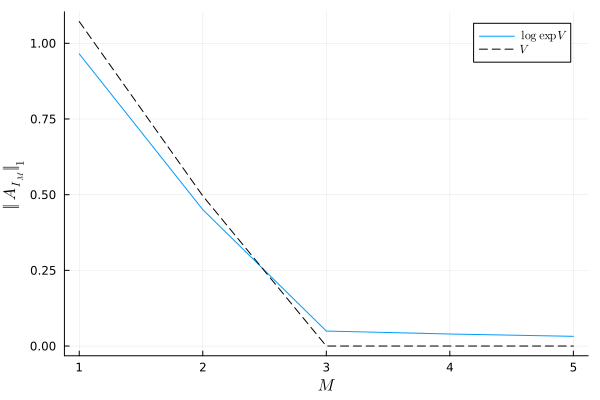

In [ ]:


t_dict = create_randomized_nth_order_operator(1, indexer; magnitude=2.0)
merge!(t_dict,create_randomized_nth_order_operator(2, indexer; magnitude=2.0))
# merge!(t_dict,create_randomized_nth_order_operator(3, indexer; magnitude=2.0))
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)

mat = Matrix(Hermitian(sparse(rows, cols, vals)))


pl = plot(xlabel=L"M", ylabel=L"\Vert A_{I_M}\Vert_1", legend=:topright)
# for (k,u) in enumerate([t_values ; U_values])
for (k,u) in enumerate(U_values[1:2])
    if k == reference_index
        hopping = mat
        # continue
        # new_U ,_ = qr(rand(size(degen_rm_U[1]*degen_rm_U[1]')...))
        # # println(new_U)
        # hopping = log(Matrix(new_U))
    else
        # hopping = log(MP(Random.shuffle(1:size(degen_rm_U[1],1)))*degen_rm_U[1]')
        hopping = log(exp(mat))
    end

    total = Dict()
    for (order, creation_annihiation) in difference_dict
        for index_list in values(creation_annihiation)
            for (i,j) in index_list
                # if abs(hopping[i,j]) > 0
                    if !(order in keys(total))
                        total[order] = [hopping[i,j]]
                    else
                        push!(total[order],hopping[i,j])
                    end
                # end
            end
        end
    end
    orders = sort(collect(keys(total)))
    average_coef = [mean(abs.(total[o])) for o in orders]
    # std_coef = [std(total[o])/sqrt(length(total[o])) for o in orders]
    if k == reference_index
        plot!(pl, orders, average_coef, label=L"V", linestyle=:dash, color=:black,xticks=orders)
    else
        plot!(pl, orders, average_coef,label=L"\log \exp V",xticks=orders)
    end
end
# plot!(pl,  ylims=(0,Inf),)
# savefig(pl,"order_images\\average_coeff_2x3_N=3.png")
# display(pl)
display(pl)
# savefig(pl, "order_images/explog_testing_N=6.png")

In [11]:
t_dict = create_randomized_nth_order_operator(1, indexer; magnitude=2.0)
merge!(t_dict,create_randomized_nth_order_operator(2, indexer; magnitude=2.0))
# t_dict3 = create_randomized_nth_order_operator(3, indexer; magnitude=0.5)
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)
mat = Matrix(Hermitian(sparse(rows, cols, vals)))
λ = eigvals(mat)

println("$(sum((λ .- minimum(λ) .> 2π)/length(λ))) of $(length(λ)), $(length(λ)-sum((λ .- minimum(λ) .> 2π)))")

0.9583333333333341 of 792, 33


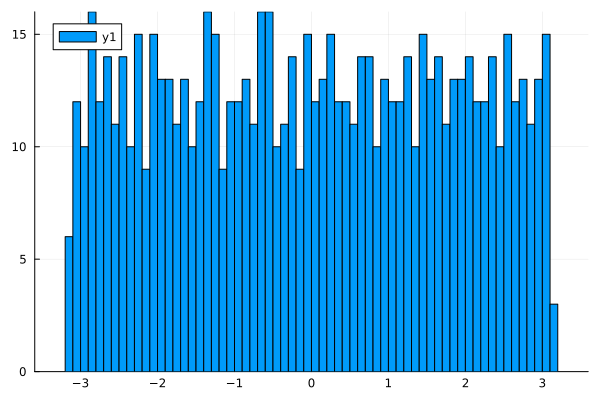

In [7]:
histogram(angle.(eigvals(exp(1im*mat))), bins=100)

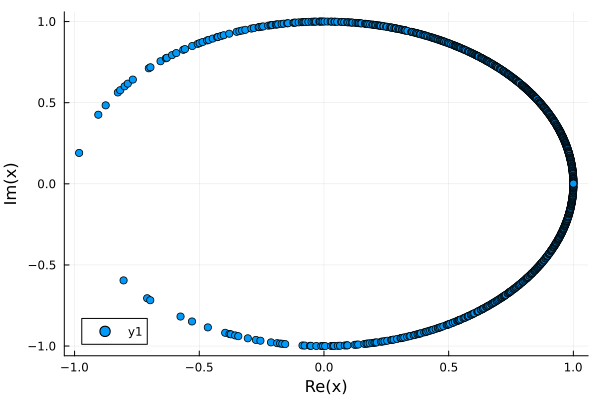

In [48]:

t_dict = create_randomized_nth_order_operator(1, indexer; magnitude=0.5)
merge!(t_dict,create_randomized_nth_order_operator(2, indexer; magnitude=0.05))
# merge!(t_dict,create_randomized_nth_order_operator(3, indexer; magnitude=0.5))
rows = Int[]
cols = Int[]
vals = Float64[]
general_n_body!(rows, cols, vals, t_dict, indexer)

mat = Matrix(Hermitian(sparse(rows, cols, vals)))

scatter(eigvals(exp(1im*mat)))

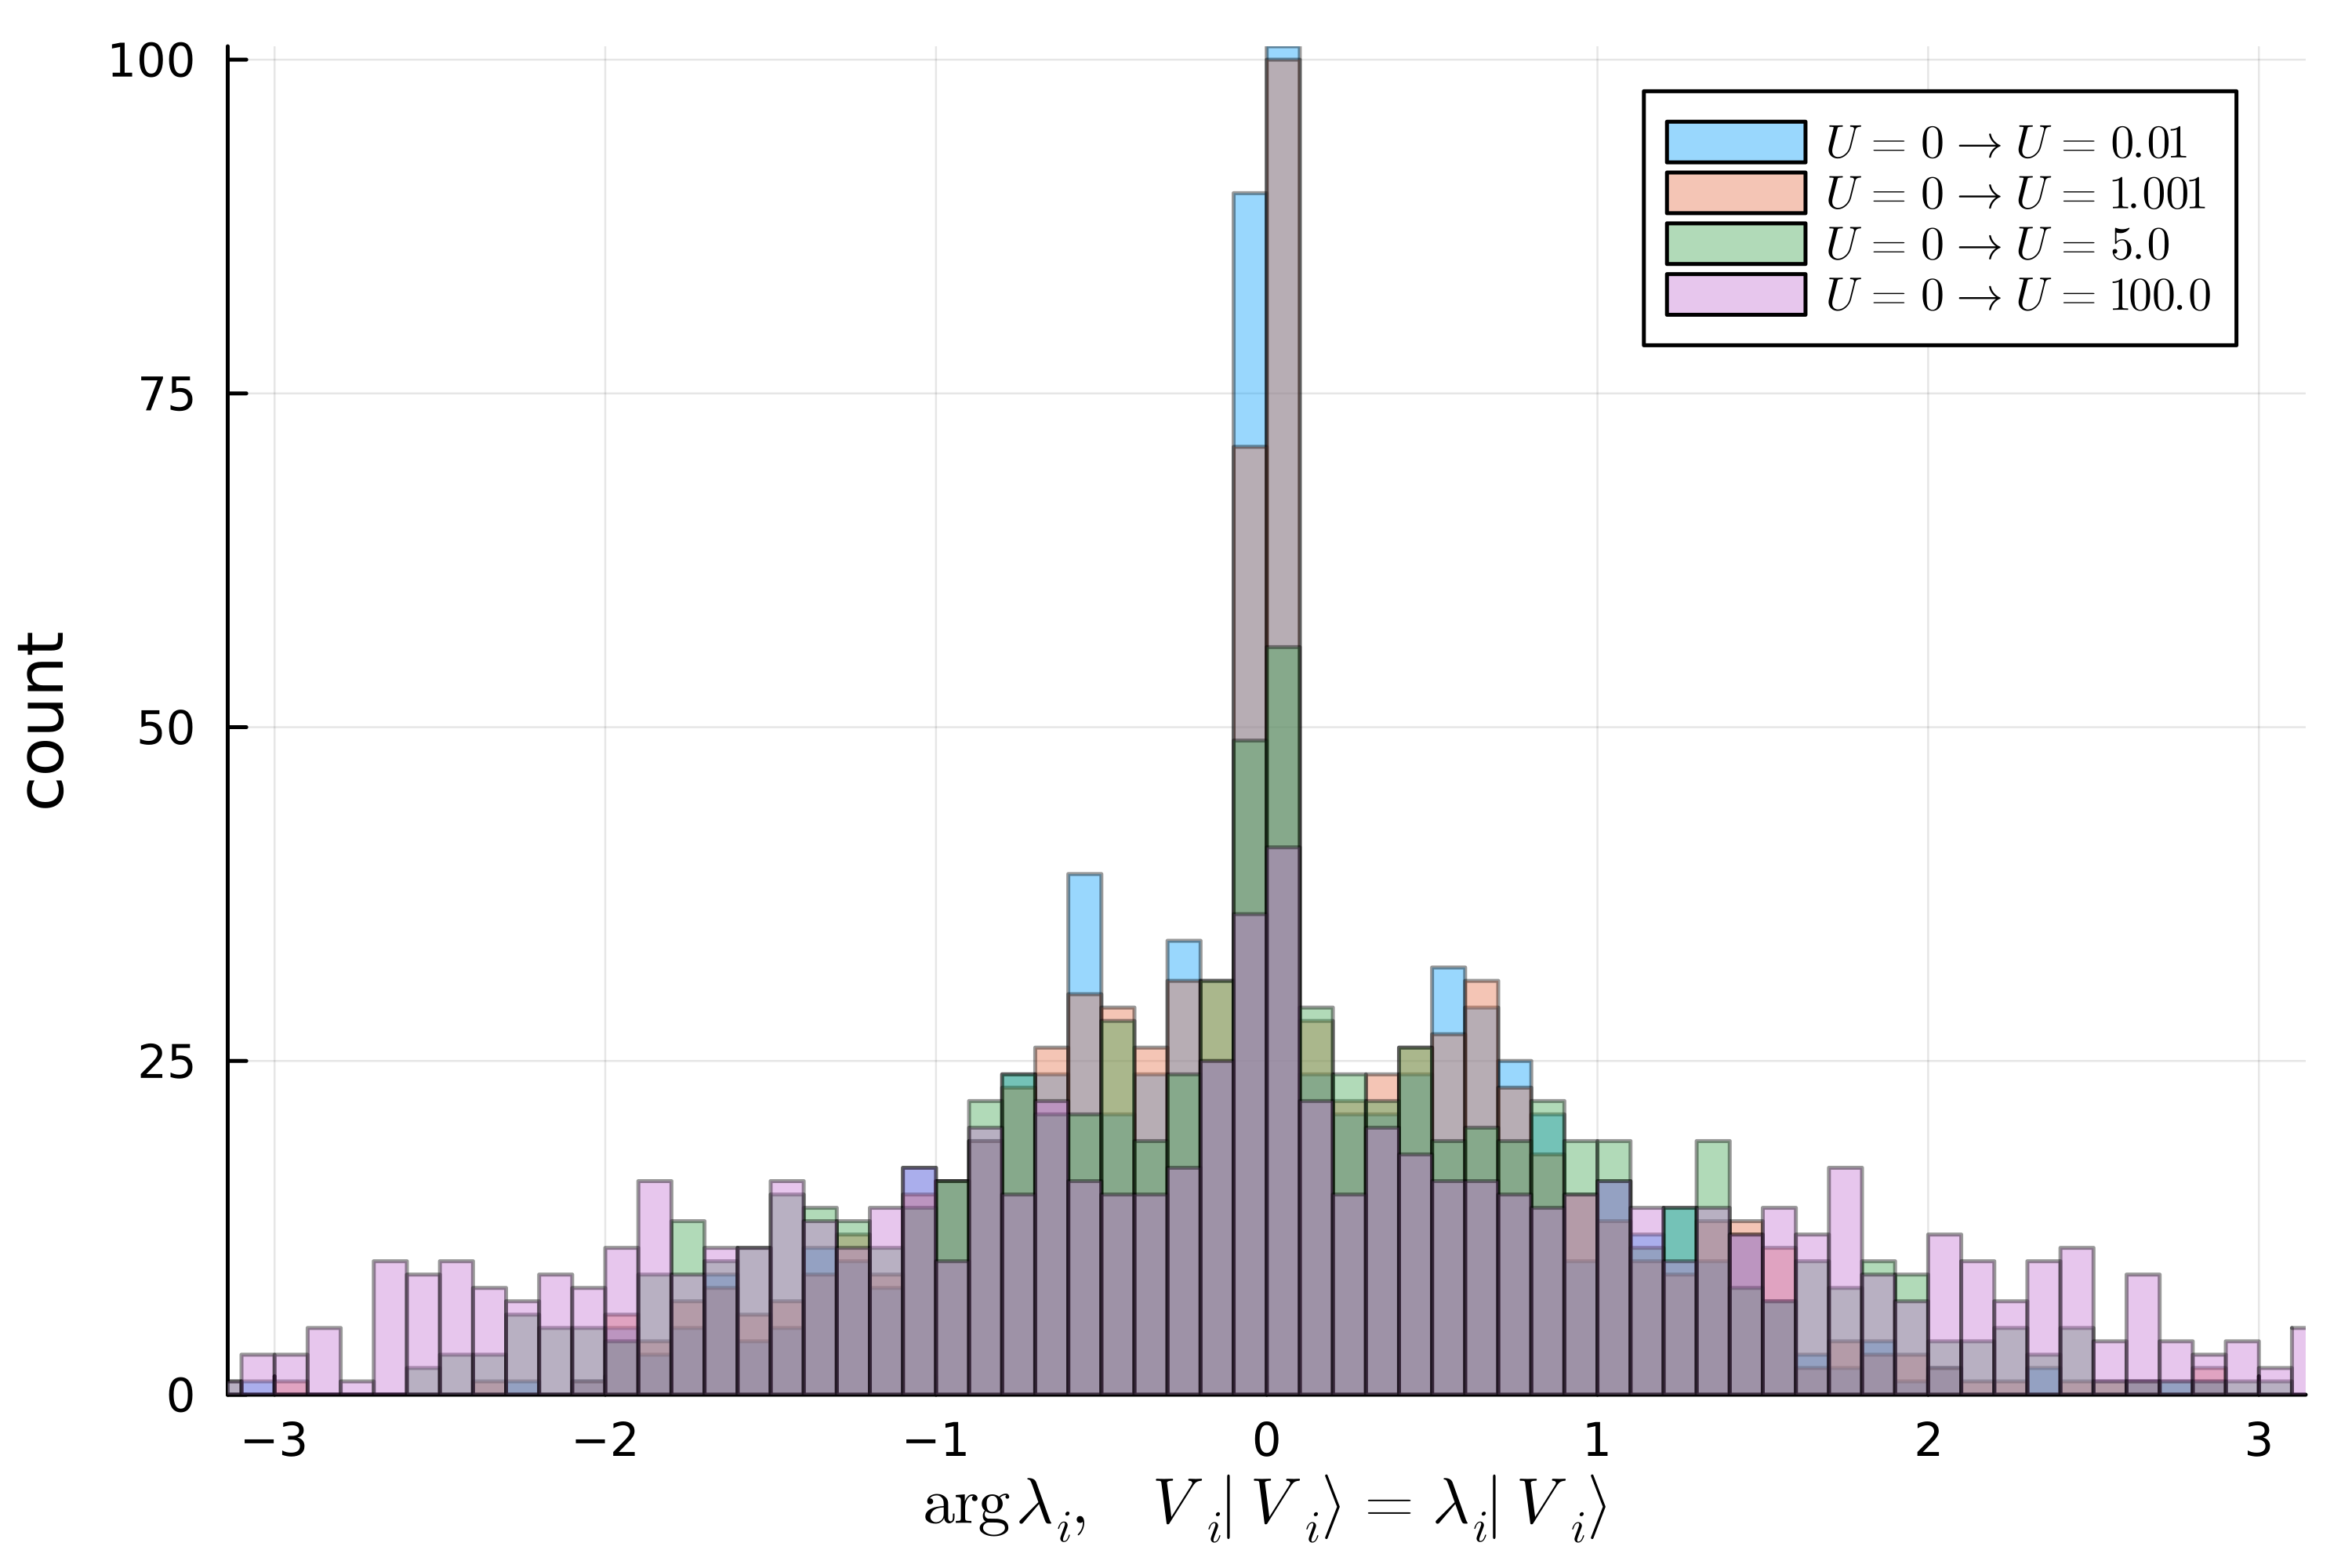

In [101]:
p = plot(xlims=[-π,π], xlabel=L"\arg \lambda_i, \quad V_i|V_i\rangle=\lambda_i |V_i\rangle", ylabel="count", dpi=500)
for i in 2:3:11
    histogram!(p, angle.(eigvals(degen_rm_U[1]*degen_rm_U[i]')), bins=100, alpha=0.4, label=L"U=0\rightarrow U=%$(U_values[i])")
end
savefig(p, "order_images/unitary_eigenvalues.png")
display(p)

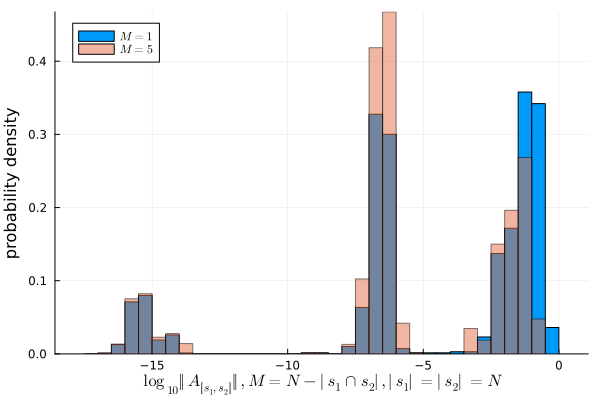

In [18]:
histogram(log10.(abs.(total[1])), normalize=:pdf, label=L"M=1")
histogram!(log10.(abs.(total[5])), normalize=:pdf, alpha=0.5, label=L"M=5", xlabel=L"\log_{10} \Vert A_{[s_1,s_2]}\Vert, M=N-|s_1\cap s_2|, |s_1|=|s_2|=N", ylabel="probability density")
# mean(abs.(filter(x-> -0.05<x<0.05,total[5]))), mean(abs.(filter(x-> -0.05<x<0.05,total[1])))

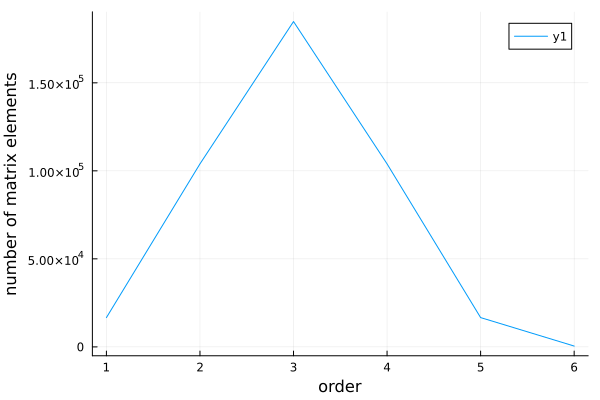

In [7]:
plot(1:maximum(collect(keys(total))), [length(total[i]) for i in 1:maximum(collect(keys(total)))], xlabel="order", ylabel="number of matrix elements")

In [ ]:
using DataStructures

h_tmp = copy(h1)
E,V = eigen(Matrix(op3))
println(counter(round.(angle.(E)/(2*pi)*360)))
h_tmp = real.(filter_matrix_by_vector(V'*h_tmp*V, E, 1))
E,V = eigen(h_tmp)
degeneracy_count(E)
# counter(round.(E*100))

Accumulator(0.0 => 39, 60.0 => 36, 180.0 => 36, 120.0 => 39, -60.0 => 36, -120.0 => 39)


Dict{Any, Any} with 3 entries:
  7 => 1
  2 => 7
  3 => 1

In [ ]:
# full_U1'*H[4]*full_U1
# sum(abs.(sort(real.(diag(full_U2'*H[4]*full_U2))) -E[4]))
full_U2*full_U1'

495×495 Matrix{ComplexF64}:
          1.0-1.93175e-18im  …   6.93889e-17-4.85723e-17im
  1.45901e-33-1.23472e-33im      7.34019e-33+2.30271e-33im
  2.88182e-18+1.25757e-17im      9.84294e-18+1.32359e-17im
  3.63069e-18+1.20987e-17im     -1.36022e-18+9.90441e-18im
 -6.29139e-34+4.93154e-33im     -1.12015e-32+5.3105e-33im
 -5.55112e-17-5.89806e-17im  …   1.11022e-16+6.93889e-18im
  4.93783e-33-6.88667e-35im      5.54204e-34+1.5287e-33im
  4.84921e-18+1.77883e-17im     -4.32814e-20+6.6255e-18im
  3.80748e-33-4.83374e-33im     -6.52998e-35+9.66335e-34im
  2.03674e-18+3.86456e-18im       -8.118e-19-3.05619e-17im
  3.62985e-18+6.00811e-18im  …  -2.06328e-17+1.54889e-18im
  2.59344e-34+1.03036e-33im      4.40207e-34+7.17239e-33im
  1.32593e-17-1.32801e-18im      3.25845e-18-1.63791e-17im
             ⋮               ⋱  
     5.04e-18+2.23986e-17im      2.00081e-18-5.03927e-19im
   4.8447e-34+2.86742e-33im     -6.01351e-33-3.48061e-33im
 -1.38778e-16-8.32667e-17im  …   1.52656e-16+9.71445e-17i

Any[-0.5, 0.75, 0, 0]


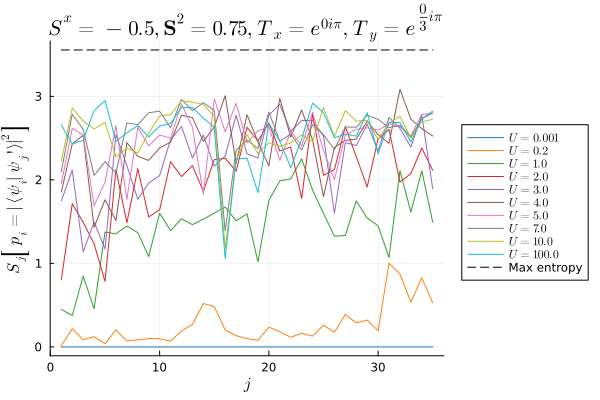

In [ ]:
i = 3
basis_transform, eigenvalues = filter_subspace([op1, op2, op4, op5], indices_of_interest[i])
_, V1, _ = schur(basis_transform'*H[1]*basis_transform)

eigenvalues[1:2] = round.(real.(eigenvalues[1:2]);digits=3)
eigenvalues[3:4] = angle.(eigenvalues[3:4])./pi
eigenvalues[4] *= 3
# eigenvalues[3] *= 2
eigenvalues[3:4] = Int.(round.(eigenvalues[3:4] ))
println(eigenvalues)
pl = plot(ylabel=L"S_j\left[p_i=|\langle \psi_i |\psi_j'\rangle|^2\right]", 
            xlabel=L"j",legend=:outerright, palette=:tab10,
            title=L"S^x=%$(eigenvalues[1]), \mathbf{S}^2=%$(eigenvalues[2]), T_x=e^{%$(eigenvalues[3]) i\pi }, T_y=e^{\frac{%$(eigenvalues[4])}{3} i\pi }")
for (u, h) in zip(U_values,H)
    _, V2, _ = schur(real.(basis_transform'*h*basis_transform))
    overlap = abs.(V1'*V2)
    p = abs.(overlap).^2
    entropy = ifelse.(p .> 0, -p .* log.(p), 0)
    # sum(entropy, dims=1)[1:7]
    # println(sqrt(tr((overlap-I)*(overlap-I)')))
    plot!(pl, collect(Iterators.flatten(sum(entropy, dims=1))),  label=L"U=%$(u)")
end
plot!(pl, [1, size(V1,1)], [log(size(V1,1)),log(size(V1,1))], label="Max entropy", linecolor=:black, linestyle=:dash)
savefig("images/entropy2x3_$(indices_of_interest[i])_N=$N.pdf")
display(pl)

In [ ]:
i = 3
basis_transform, eigenvalues = filter_subspace([op1, op2, op4, op5], indices_of_interest[i])
_, V1, _ = schur(real.(basis_transform'*H[1]*basis_transform))
_, V2, _ = schur(real.(basis_transform'*H[2]*basis_transform))
# sum(abs2.(basis_transform*V1*basis_transform')[1,:])
sum(abs2.(V1[1,:]))

0.9999999999999996

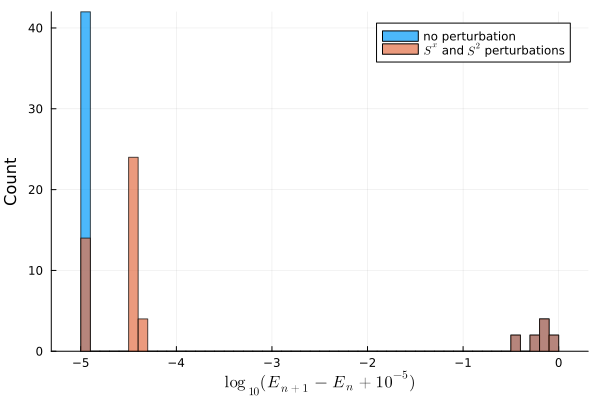

In [17]:
using StatsBase
epsilon = 1e-5

histogram(log10.(diff(real.(E[1])).+1e-5),bins=-5:0.1:0, label="no perturbation", ylabel="Count", xlabel=L"\log_{10}(E_{n+1}-E_{n}+10^{-5})",alpha=0.7)
histogram!(log10.(diff(real.(E[2])).+1e-5),bins=-5:0.1:0, label=L"$S^x$ and $S^2$ perturbations",alpha=0.7)
# plot!([0,250],[epsilon, epsilon],color="black")
# plot!(diff(E2))
# savefig("3x3_N=5_perturbation_effect.pdf")

In [ ]:
s1 = Set(findall(x-> (x<1e-6), diff(E1)))
s2 = Set(findall(x-> (x<1e-6), diff(E2)))
println(length(setdiff(union(s1,s2),symdiff(s1, s2))) - min(length(s2), length(s1)))

setdiff(s1, s2)

-4


Set{Int64} with 4 elements:
  484
  627
  505
  620

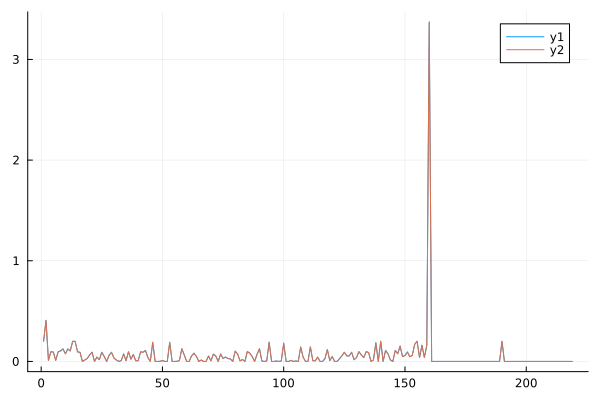

In [13]:
plot(abs.(diff(diag(V1'*H2*V1))))
plot!(abs.(diff(diag(V2'*H2*V2))))

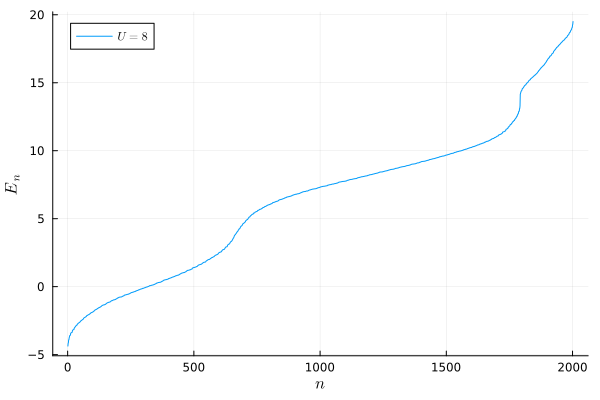

In [241]:
plot(E1, label=L"U=8", xlabel=L"n", ylabel=L"E_n")
# plot!(E2, label=L"U=16")
# plot!(E3, label=L"U=4")
# plot!(E5, label=L"U=7")
# plot!(E1,label=L"U=8")
# plot!(E6, label=L"U=10")
# savefig("3x3_mu=0_N=5.pdf")

In [43]:
U = V1'*V2 # energy basis
# sum(abs.(V1*U - V2))

p = abs.(U).^2
entropy = ifelse.(p .> 0, -p .* log.(p), 0)
# sum(entropy, dims=1)[1:7]
println(sqrt(tr((U-I)*(U-I)')))
sort(collect(Iterators.flatten(sum(entropy, dims=1))))

21.164111439747483


220-element Vector{Real}:
 -1.3322676294594337e-15
 -1.3322675877401919e-15
 -8.881784196489471e-16
 -8.881784152110461e-16
 -8.881783946470448e-16
 -8.881783728964097e-16
 -8.881781775751524e-16
 -4.4408920984410603e-16
 -4.4408920984340616e-16
 -4.440892094559743e-16
 -4.4408920901550995e-16
 -4.4408920843433108e-16
 -4.440892017035139e-16
  ⋮
  2.112446709904766
  2.117842350510945
  2.1233866932571486
  2.131917590078454
  2.1538853908616704
  2.1563823776925948
  2.183380225527846
  2.215692199846435
  2.315467625742235
  2.315467625745109
  2.350202161265325
  2.350202161265331

In [26]:
U = V2*V1' # computational basis 

# this unitary makes more sense to compute the quantum complexity of
p = abs.(U).^2
entropy = ifelse.(p .> 0, -p .* log.(p), 0)
sum(entropy, dims=1)[1:7]

7-element Vector{Float64}:
 4.67502010839971
 4.680287262859502
 4.659354108209212
 4.424107517776376
 4.6178977430646215
 4.729190837543825
 4.55988444900022

In [203]:
sort(diag(U))

56-element Vector{Float64}:
 -0.3622350403989767
 -0.2992150624609179
 -0.28993672285175137
 -0.21152239006569346
 -0.18832856913509408
 -0.1797076847870786
 -0.16965019734967052
 -0.16877421666506393
 -0.14366475399341608
 -0.13935394727038908
  ⋮
  0.10492454137675775
  0.12499828731651998
  0.12499915911691023
  0.2006406396609804
  0.20268272751856967
  0.24772500474752243
  0.3003698974614383
  0.3727207820225861
  0.420179608426703

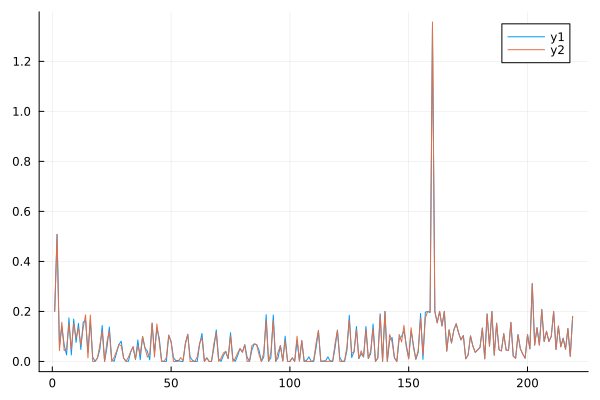

In [58]:
using Plots
plot(diff(E1))
plot!(diff(E2))

In [176]:
cicj = [dot(V2[:,3], cicj_array2[i,j,k]*V2[:,3]) for i=1:4, j=1:4, k=1:2]
for i=1:4
    println(cicj[i,i,1] + cicj[i,i,2])
end

0.749277920394003
0.7507255718773945
0.7507221048571685
0.7492744028714353


# Heisenberg 

In [5]:
N=2
lattice = Graphs.grid((2,2))
# lattice = Graphs.cycle_graph(3)

subspace = HubbardSubspace(N, lattice)
# subspace = HubbardSubspace(N_up, N_down, lattice)
h,indexer = create_Heisenberg(1.0, 0.5, subspace)

E,V = eigen(Matrix(h))
println(E)
psi0 = maximum(V[:,1])
for (i, psi) in enumerate(V[:,1])
    if abs.(psi) > 1e-8
        println(psi, " ", combination(indexer, i))
    end
end

[-3.22817805262833, -1.8789024427351722, -1.8789024427351722, -1.8789024427351713, -1.8789024427351713, -1.8789024427351713, -1.8789024427351642, -0.7500000000000022, -0.7499999999999953, -0.7499999999999949, 0.0, 0.0, 5.204170427930421e-17, 5.174920444975781e-16, 2.7555905900771413e-15, 0.25000000000000067, 0.2500000000000009, 0.2500000000000018, 0.2500000000000018, 0.250000000000002, 0.250000000000002, 2.1289024427351744, 2.1289024427351744, 2.128902442735175, 2.128902442735175, 2.128902442735175, 2.1289024427351753, 2.4781780526283317]
-0.2659220264360266 (Set([1]), Set([2]))
-0.2659220264360278 (Set([1]), Set([3]))
0.3295010648121068 (Set([1]), Set([4]))
0.26592202643602886 (Set([2]), Set([1]))
0.3295010648121091 (Set([2]), Set([3]))
-0.26592202643602775 (Set([2]), Set([4]))
0.2659220264360277 (Set([3]), Set([1]))
-0.32950106481210656 (Set([3]), Set([2]))
-0.2659220264360278 (Set([3]), Set([4]))
-0.32950106481210883 (Set([4]), Set([1]))
0.2659220264360276 (Set([4]), Set([2]))
0.265

# test

In [ ]:
# this attempt to see if there are any unitary transforms that 
# map the hubbard model to a density-density interaction model. The
# answer seems to be no, since only a unitary that commutes with the 
# Hamiltonian satisfies the constraint.
using LinearAlgebra
N = 5
Vp = rand(N,N)
tp = rand(N,N)
coefficients = zeros(N^3,2N^2)
convert_to_index(i,j) = (i-1)*N + j
convert_to_index(i,j,k) = (i-1)*N^2 + (j-1)*N + k
for (i,j,k) in Iterators.product(1:N, 1:N, 1:N)
    index = convert_to_index(i,j,k)
    coefficients[index, convert_to_index(k,i)] += Vp[i,j]-Vp[k,j]
    coefficients[index, convert_to_index(k,j)] += Vp[j,i]
    coefficients[index, convert_to_index(j,i)] += -Vp[j,k]

    coefficients[index, convert_to_index(i,j) + N^2] += -tp[k,i]
    coefficients[index, convert_to_index(j,i) + N^2] += -tp[k,j]
    coefficients[index, convert_to_index(k,j) + N^2] += tp[k,i]
    coefficients[index, convert_to_index(j,k) + N^2] += tp[j,i]
end
nullspace(coefficients)

50×1 Matrix{Float64}:
 0.16494158780944476
 0.1449519372457409
 0.04135351413576674
 0.16859104363942065
 0.20375454521249475
 0.1755925757934566
 0.14674946556946833
 0.07662602714201561
 0.14911511546543396
 0.20071850747242637
 0.12466895442338624
 0.22168736618288148
 0.02099487050589935
 ⋮
 0.04733686495791092
 0.022925758425951594
 0.12920987252455568
 0.22695664577273458
 0.10615683408636473
 0.19385937487464444
 0.065012283584813
 0.0075372541325304885
 0.17501632989589408
 0.07496970961599618
 0.15781500659950892
 0.10171354317531481

# Optimization

In [ ]:

# dim = get_subspace_dimension(subspace)
# indexer = CombinationIndexer(reduce(vcat,collect(sites(subspace.lattice))), get_subspace_info(subspace)...)

state1 = degen_rm_U[1][:,1] # ground state
state2 = degen_rm_U[5][:,2] # these states are non-degenerate and slater determinants
computed_matrices = []
initial_magnitude = 1-abs2(state1'*state2)
if initial_magnitude < 1e-8
    println("States are already equal")
    throw("Error")
end
for order = 1:2
    t_dict = create_randomized_nth_order_operator(order,indexer;magnitude=0.5)
    t_keys = collect(keys(t_dict))
    # println(t_dict)
    t_vals = collect(values(t_dict))
    rows, cols, signs, ops_list = build_n_body_structure(t_dict, indexer)
        
    # general_single_body!(rows, cols, vals, t_dict, indexer)
    # general_n_body!(rows, cols, vals, t_dict, indexer)

    # vals = update_values(signs, conjugate, ops_list, t_dict)
    # eigvals(Matrix(sparse(rows, cols, vals, dim, dim)))


    function f(t_vals, p=nothing)
        vals = update_values(signs, ops_list, Dict(zip(t_keys,t_vals)))
        mat = Matrix(Hermitian(sparse(rows, cols, vals, dim, dim)))
        if p isa AbstractMatrix
            mat += p
        end
        loss = 1-abs2(state2'*exp(1im*mat)*state1)
        println(loss)
        return loss
    end

    optf = OptimizationFunction(f, Optimization.AutoZygote())

    if length(computed_matrices) > 0
        prob = OptimizationProblem(optf, t_vals,sum(computed_matrices))
    else
        prob = OptimizationProblem(optf, t_vals)
    end
    opt = OptimizationOptimisers.Adam(0.1)
    sol = solve(prob, opt, maxiters = 100)
    
    vals = update_values(signs, ops_list, Dict(zip(t_keys,sol.u)))
    push!(computed_matrices,Hermitian(sparse(rows, cols, vals, dim, dim)))
    println("Finished order $order")
end

In [ ]:
meta_data = Dict("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                "U_values"=>U_values, "maxiters"=>100)
instructions = Dict("starting state"=>Dict("U index"=>1, "levels"=>1:20),
                "ending state"=>Dict("U index"=>5, "levels"=>20))
data_dict_tmp = test_map_to_gs(degen_rm_U, instructions, indexer; maxiters=meta_data["maxiters"])
data_dict_tmp["meta_data"] = meta_data
append_to_json_files(data_dict_tmp, "single_particle_unitary_tests")

magnitude: 0.5
learning rate: 0.1
  0.000054 seconds (807 allocations: 50.469 KiB)
  0.025117 seconds (472.61 k allocations: 54.594 MiB)
0.9997004398093956
0.9641711584024193
0.9039599774616187
0.8469728666170167
0.801426069948179
0.7570800267193231
0.7059816285348557
0.6563368405326543
0.6233273660519583
0.6039111597299749
0.5924505680284302
0.5829734681357174
0.5716312655885643
0.5594271110107379
0.548064992802854
0.5395362830601234
0.5333776597667814
0.5286190914404373
0.5265375940286019
0.5270979670973407
0.5280014676810065
0.5270405377317844
0.5236760140516463
0.5183442231492036
0.5133160691231223
0.5107751229439167
0.5100394792874237
0.5094855378616034
0.5085486302011657
0.5072275496255261
0.5056344903325705
0.5044932150013589
0.5041574899671792
0.5039771019317586
0.5032460291163248
0.5020404864880573
0.500911427218294
0.5002425196144227
0.5001231422969363
0.5000384643605964
0.4995603019560726
0.49901895349449843
0.49883623314507963
0.498847291052706
0.49864191368965893
0.4982292

"single_particle_unitary_tests"

In [5]:
meta_data = Dict("electron count"=>5, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                "U_values"=>U_values, "maxiters"=>100)
instructions = Dict("starting state"=>Dict("U index"=>1, "levels"=>23),
                "ending state"=>Dict("U index"=>5, "levels"=>91), "max_order"=>1)
data_dict_tmp = test_map_to_gs(degen_rm_U, instructions, indexer; maxiters=meta_data["maxiters"])
data_dict_tmp["meta_data"] = meta_data
append_to_json_files(data_dict_tmp, "single_particle_unitary_tests_N=5")

magnitude: 0.5
learning rate: 0.1
  0.000065 seconds (807 allocations: 50.469 KiB)
  0.162361 seconds (1.81 M allocations: 223.140 MiB, 22.18% gc time)
0.9998388260832223
0.9793446464535662
0.9409032281455202
0.8934788786907548
0.8475165606610638
0.8134008666625346
0.7935965467254691
0.7805493478909811
0.7713629637679114
0.7641899633028143
0.7565839466557605
0.7481861339417795
0.7420631348210207
0.7396729172661272
0.7396219868580907
0.7395847073326243
0.7383229853968138
0.7362578078431463
0.7340107937362408
0.7316518207792917
0.7294043719395544
0.7276526082007546
0.7262395857771815
0.7247088281839515
0.7231474579995077
0.722146976677035
0.7215506869011747
0.7207472575795117
0.7198332044982856
0.7191763283437906
0.7186649835611011
0.7182298361430137
0.718087260940492
0.718046120091139
0.7176799652858655
0.7170248311692553
0.7164251823323647
0.7160354147741745
0.7158705632686513
0.7158646099190498
0.7157913590052286
0.7155548382608123
0.7152993979639083
0.7151309410021958
0.7150562872220

"single_particle_unitary_tests_N=5"

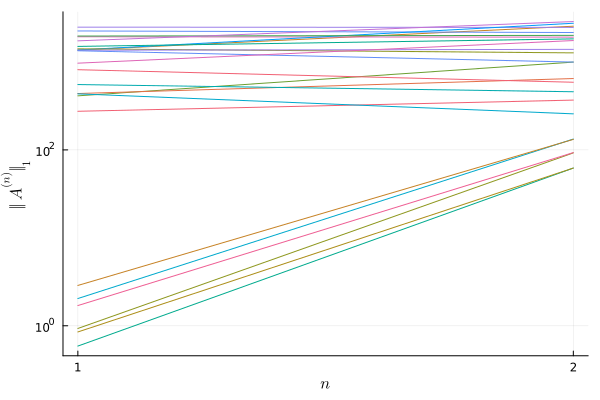

1 0
2 0
3 0
4 0
5 0
6 0
7 0
8 2547.938233483414
9 62.1865928818649
10 92.49659308138926
11 132.80552474292804
12 2469.446583768928
13 2160.087044480898
14 368.2123238087485
15 1913.8894464356865
16 996.3851647839339
17 2753.425691833072
18 647.3708570074032
19 2004.441753512793
20 2878.566315601931
21 62.140866030109315
22 458.12702971889166
23 93.17735430484245
24 131.73347469656545
25 1828.1676825484676
26 1267.8827387981394
27 256.90313574312245
28 1389.8148112490262
29 996.4316556002038
30 587.6202179703545
31 1750.4550497855212
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
40 0


In [14]:
data_dict3 = load_json_folder("single_particle_equal_state_unitary_tests")
p = plot(legend=false, xlabel=L"n",yscale=:log10,ylabel=L"\Vert A^{(n)}\Vert_1", xticks=[0,1,2])
for (label, v) in zip(data_dict3["labels"], data_dict3["norm1_metrics"])
    if length(v) >= 2
        println("$(label["starting state"]["level"]) $(v[2])")
    else
        println("$(label["starting state"]["level"]) 0")
    end
    plot!(p, [1,2][1:length(v)], v)
end
savefig(p, "single_state_map_images/norm1.png")
display(p)


In [6]:
for i in 21:40
    meta_data = Dict{String, Any}("electron count"=>3, "sites"=>"2x3", "bc"=>"periodic", "basis"=>"adiabatic", 
                    "U_values"=>U_values, "maxiters"=>100)
    instructions = Dict{String, Any}("starting state"=>Dict("U index"=>1, "levels"=>i),
                    "ending state"=>Dict("U index"=>5, "levels"=>i))
    data_dict_tmp3 = test_map_to_gs(degen_rm_U, instructions, indexer; maxiters=meta_data["maxiters"])
    data_dict_tmp3["meta_data"] = meta_data
    append_to_json_files(data_dict_tmp3, "single_particle_equal_state_unitary_tests")
end

magnitude: 0.002997429457810452
learning rate: 0.0005994858915620904
  0.000063 seconds (807 allocations: 50.469 KiB)
  0.032252 seconds (472.61 k allocations: 54.594 MiB, 18.05% gc time)
0.006016758044065318
0.006002516725595486
0.005999531872723951
0.006000772658124598
0.00600115256574929
0.006000279994853974
0.0059989712096192305
0.0059978586717673865
0.0059972982826409504
0.005997260313391428
0.005997353504240244
0.005997178893623389
0.005996745714715868
0.005996325032329275
0.005996127084580638
0.005996161849681658
0.0059962553660772855
0.005996193918162085
0.005995947614002128
0.005995682183995488
0.0059955457061555695
0.005995525497429655
0.0059955238871113314
0.005995490117259528
0.005995435843098695
0.005995379379314714
0.00599532164008687
0.005995256538619764
0.005995185384748636
0.005995129378226216
0.005995116451500637
0.005995139682648087
0.005995150674295346
0.005995114106432831
0.0059950498203414915
0.005995002826812312
0.005994991352597623
0.005995000274881868
0.0059950

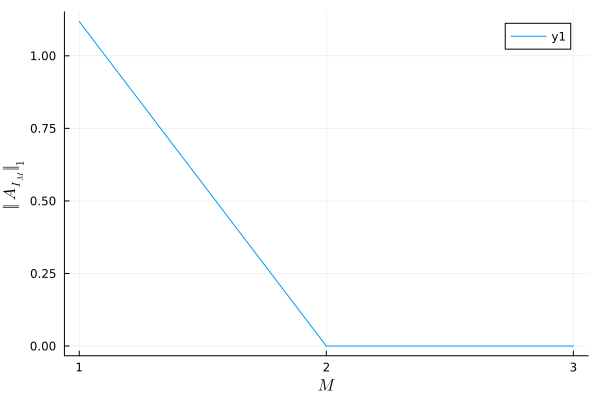

In [ ]:
vals = update_values(signs, ops_list, Dict(zip(t_keys,t_vals)))
mat = exp(1im*Matrix(Hermitian(sparse(rows, cols, vals, dim, dim)))/100)
# second_quantized_solution, second_quantized_nullspace, second_quantized_order_labels = find_N_body_interactions(mat, indexer)

pl = plot(xlabel=L"M", ylabel=L"\Vert A_{I_M}\Vert_1", legend=:topright)
# for (k,u) in enumerate([t_values ; U_values])
hopping = log(mat)*100
total = Dict()
for (order, creation_annihiation) in difference_dict
    for index_list in values(creation_annihiation)
        for (i,j) in index_list
            # if abs(hopping[i,j]) > 0
                if !(order in keys(total))
                    total[order] = [hopping[i,j]]
                else
                    push!(total[order],hopping[i,j])
                end
            # end
        end
    end
end
orders = sort(collect(keys(total)))
average_coef = [mean(abs.(total[o])) for o in orders]
# std_coef = [std(total[o])/sqrt(length(total[o])) for o in orders]

plot!(pl, orders, average_coef,xticks=orders)


# plot!(pl,  ylims=(0,Inf),)
# savefig(pl,"order_images\\average_coeff_2x3_N=3.png")
display(pl)